# Fashion MNIST Project


In [1]:
import os, sys, random
import matplotlib
import torch, torchvision
import warnings
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
root = os.getcwd()

data_folder = os.path.join(root, 'data')
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

In [3]:
use_gpu = torch.cuda.is_available()

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

print('Using Device: {}'.format(device))

Using Device: cpu


Defining the transforms to be applied to the dataset

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
fmnist_train_full = torchvision.datasets.FashionMNIST(root=data_folder, transform=data_transform, train=True, download=True) # Loading training dataset
fmnist_test = torchvision.datasets.FashionMNIST(root=data_folder, transform=data_transform, train=False, download=True) # Loading testing dataset

len(fmnist_train_full), len(fmnist_test)

(60000, 10000)

In [6]:
def train_val_split(m_data, val_per):
    val_size = int(val_per * len(m_data))
    train_size = len(m_data) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(m_data, [train_size, val_size])
    return train_dataset, val_dataset

fmnist_train, fmnist_val = train_val_split(fmnist_train_full, 0.3)

len(fmnist_train), len(fmnist_val), len(fmnist_test)

(42000, 18000, 10000)

Function to display images

In [7]:
def disp_org_dec(in_img, out_img, n):
    ind_show = random.sample(list(range(len(in_img))), n) # Sampling n random indices from training dataset

    org_img = [in_img[k] for k in ind_show]
    new_img = [out_img[k] for k in ind_show]
    total = 2*n

    fig = plt.figure(1)
    for k in range(total):
        if k < total//2:
            ax = fig.add_subplot(2,n,k+1)
            ax.title.set_text('Original')
            ax.axis('off')
            ax.imshow(org_img[k], cmap='gray')
        else:
            ax = fig.add_subplot(2,n,k+1)
            ax.title.set_text('Generated')
            ax.axis('off')
            ax.imshow(new_img[k - total//2], cmap='gray')

    plt.show()

def disp_img(imgs):
    fig = plt.figure(1)
    for k in range(len(imgs)):
        ax = fig.add_subplot(1,len(imgs),k+1)
        ax.title.set_text('Generated')
        ax.axis('off')
        ax.imshow(imgs[k], cmap='gray')

    plt.show()

def disp_img_2r(imgs):
    fig = plt.figure(1)
    if len(imgs) % 2 == 0:
        n = len(imgs)//2
    else:
        n = len(imgs)//2 + 1

    for k in range(len(imgs)):
        ax = fig.add_subplot(2,n,k+1)
        ax.title.set_text('Gen')
        ax.axis('off')
        ax.imshow(imgs[k], cmap='gray')

    plt.show()

def disp_interp_imgs(img_data):
    total = len(img_data)
    img_num = total
    if np.sqrt(img_num) != int(np.sqrt(img_num)):
        col = int(np.sqrt(img_num)) + 1
    else:
        col = int(np.sqrt(img_num))
    rows = total // col
    if total % col != 0:
        rows += 1

    fig = plt.figure(1)
    for k in range(total):
        ax = fig.add_subplot(rows,col,k+1)
        ax.axis('off')
        ax.imshow(img_data[k], cmap='gray')

    plt.show()

Defining the VAE neural network

In [8]:
class CNN_VAE_1(nn.Module):
    def __init__(self, in_channels, img_size, latent_dim):
        super(CNN_VAE_1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.convlayer1 = 10
        self.convlayer2 = 20

        # Initializing the 2 convolutional layers and 2 separate full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.convlayer1, kernel_size=3, padding=1)
        self.encConv2 = nn.Conv2d(in_channels=self.convlayer1, out_channels=self.convlayer2, kernel_size=3, padding=1)
        self.encFC1 = nn.Linear(self.convlayer2*self.img_size[0]*self.img_size[1], self.latent_dim*2)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(self.latent_dim, self.convlayer2*self.img_size[0]*self.img_size[1])
        self.decConv1 = nn.ConvTranspose2d(in_channels=self.convlayer2, out_channels=self.convlayer1, kernel_size=3, padding=1)
        self.decConv2 = nn.ConvTranspose2d(in_channels=self.convlayer1, out_channels=self.out_channels, kernel_size=3, padding=1)

    def encode(self, x):
        # Passing the input through 2 convolutional layers - 3x3 kernel with 1 padding so the image size remains same

        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))

        # Flattening the layer
        x = x.view(-1, self.convlayer2*self.img_size[0]*self.img_size[1])

        # Passing the flattened layer through 2 different fully-connected layers to get mu and log_var values separately
        mu_log_var = self.encFC1(x)

        return mu_log_var

    def reparameterize(self, mu, log_var):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        # The random value, z, generated using mu and std is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input

        x = F.relu(self.decFC1(z))
        x = x.view(-1, self.convlayer2, self.img_size[0], self.img_size[1])
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation

        mu_log_var = self.encode(x).view(-1, 2, self.latent_dim)
        mu = mu_log_var[:, 0, :]
        log_var = mu_log_var[:, 1, :]

        z = self.reparameterize(mu, log_var)

        out = self.decode(z)

        return out, mu, log_var

    def generate(self, N=10):
        z = torch.randn((N, self.latent_dim)).to(device)
        gen_img = self.decode(z)
        print(gen_img.size())
        return torch.squeeze(gen_img).detach().cpu().numpy()

Defining a loss function

In [9]:
def auto_encode_loss_function(x_hat, x, mu, logvar, img_size, beta=1):
    recon_loss = nn.functional.mse_loss(x_hat.view(-1, img_size[0]*img_size[1]), x.view(-1, img_size[0]*img_size[1]), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

In [10]:
def train_val_vae(model, optimiser, num_epochs, num_workers, batch_size, train_set, val_set, img_size):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    train_loss = []
    val_loss = []

    opt = optimiser

    for epoch in range(num_epochs):
        # print("Epoch {} Starting".format(epoch+1))
        running_loss = 0.0
        N_tot = 0
        model.train()

        for ix, data in enumerate(train_loader):
            input_img, labels = data
            input_img = input_img.to(torch.float).to(device)
            labels = labels.to(torch.long).to(device)
            out_img, mu, log_var = model(input_img)
            opt.zero_grad()
            loss = auto_encode_loss_function(out_img, input_img, mu, log_var, img_size)
            loss.backward()
            opt.step()

            N_tot += out_img.size(0)
            running_loss += loss.item() * out_img.size(0)

        train_loss.append(running_loss / N_tot)

        print('| Epoch:[{}]\tTrain_Loss: {:.4f}'.format(epoch + 1, running_loss / N_tot))

        val_in_imgs = np.empty((len(fmnist_val), img_size[0], img_size[1]))
        val_out_imgs = np.empty((len(fmnist_val), img_size[0], img_size[1]))
        n_line = 0
        N_tot = 0
        running_loss = 0
        model.eval()
        for ix, data in enumerate(val_loader):
            input_img, labels = data
            input_img = input_img.to(torch.float).to(device)
            labels = labels.to(torch.long).to(device)
            out_img, mu, log_var = model(input_img)
            loss = auto_encode_loss_function(out_img, input_img, mu, log_var, img_size)
            N_tot += out_img.size(0)
            running_loss += loss.item() * out_img.size(0)

            val_in_imgs[n_line:n_line+out_img.size(0)] = torch.squeeze(input_img).cpu().numpy()
            val_out_imgs[n_line:n_line+out_img.size(0)] = torch.squeeze(out_img).detach().cpu().numpy()
            n_line += out_img.size(0)

        val_loss.append(running_loss / N_tot)

        print('| Epoch:[{}]\tValid_Loss: {:.4f}'.format(epoch + 1, running_loss / N_tot))
        print('\n')


        if epoch >= num_epochs-6:
            disp_org_dec(val_in_imgs, val_out_imgs, 4)

        sys.stdout.flush()

    return train_loss, val_loss

def test_vae(model, num_epochs, num_workers, batch_size, learning_rate, test_set, img_size):
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_in_imgs = np.empty((len(fmnist_test), img_size[0], img_size[1]))
    test_out_imgs = np.empty((len(fmnist_test), img_size[0], img_size[1]))
    means, log_vars, label_list = [],[],[]

    running_loss = 0.0
    N_tot = 0
    n_line = 0

    model.eval()
    for ix, data in enumerate(test_loader):
        input_img, labels = data
        input_img = input_img.to(torch.float).to(device)
        labels = labels.to(torch.long).to(device)
        out_img, mu, log_var = model(input_img)
        loss = auto_encode_loss_function(out_img, input_img, mu, log_var, img_size)

        N_tot += out_img.size(0)
        running_loss += loss.item() * out_img.size(0)

        test_in_imgs[n_line:n_line+out_img.size(0)] = torch.squeeze(input_img).cpu().numpy()
        test_out_imgs[n_line:n_line+out_img.size(0)] = torch.squeeze(out_img).detach().cpu().numpy()
        n_line += out_img.size(0)

        means.append(mu.detach())
        log_vars.append(log_var.detach())
        label_list.append(labels.detach())


    print('| Test_Loss: {:.4f}'.format(running_loss / N_tot))
    print('\n')

    disp_org_dec(test_in_imgs, test_out_imgs, 5)

    sys.stdout.flush()

    return test_in_imgs, test_out_imgs, means, log_vars, label_list, running_loss / N_tot

Training the VAE model - Displaying 4 orig-decoded images after each epoch to show the progress. Displaying 5 orig-decoded images from the test dataset to show the model performance on completely new data.
Training for number of epochs given below, but displaying results from the last 5 epochs

| Epoch:[1]	Train_Loss: 146164.2546
| Epoch:[1]	Valid_Loss: 131240.4789


| Epoch:[2]	Train_Loss: 129008.0204
| Epoch:[2]	Valid_Loss: 126813.9768


| Epoch:[3]	Train_Loss: 126207.7193
| Epoch:[3]	Valid_Loss: 125092.6222


| Epoch:[4]	Train_Loss: 124980.1503
| Epoch:[4]	Valid_Loss: 124173.9380


| Epoch:[5]	Train_Loss: 124304.0098
| Epoch:[5]	Valid_Loss: 123681.9877


| Epoch:[6]	Train_Loss: 123896.3431
| Epoch:[6]	Valid_Loss: 123397.6625


| Epoch:[7]	Train_Loss: 123625.3989
| Epoch:[7]	Valid_Loss: 123137.1121


| Epoch:[8]	Train_Loss: 123433.5635
| Epoch:[8]	Valid_Loss: 123032.6429


| Epoch:[9]	Train_Loss: 123279.3520
| Epoch:[9]	Valid_Loss: 122801.4192


| Epoch:[10]	Train_Loss: 123159.1435
| Epoch:[10]	Valid_Loss: 122703.6640


| Epoch:[11]	Train_Loss: 123057.8291
| Epoch:[11]	Valid_Loss: 122607.1701


| Epoch:[12]	Train_Loss: 122965.8907
| Epoch:[12]	Valid_Loss: 122567.1677


| Epoch:[13]	Train_Loss: 122894.4751
| Epoch:[13]	Valid_Loss: 122647.2659


| Epoch:[14]	Train_Loss: 12282

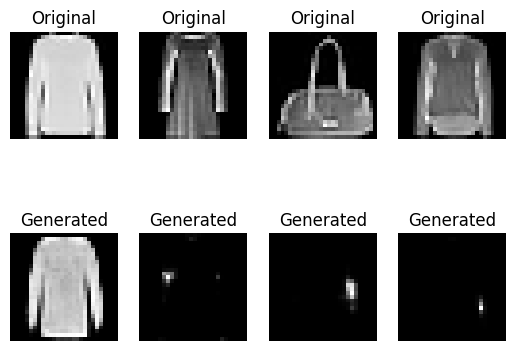

| Epoch:[21]	Train_Loss: 122540.9039
| Epoch:[21]	Valid_Loss: 122209.0642




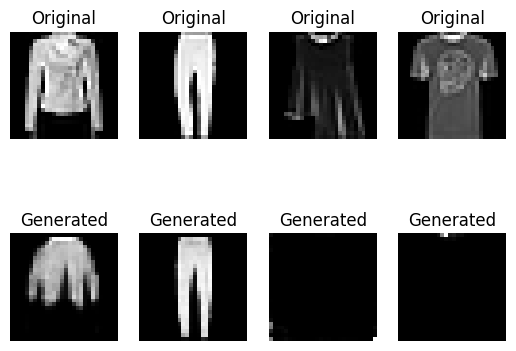

| Epoch:[22]	Train_Loss: 122515.5550
| Epoch:[22]	Valid_Loss: 122147.4438




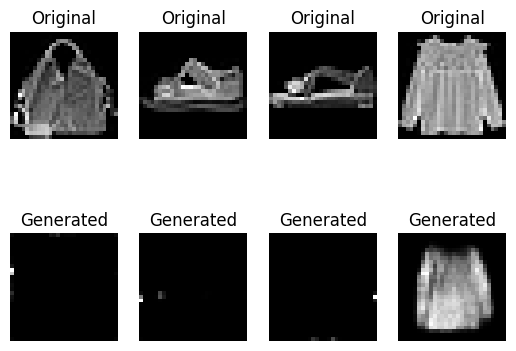

| Epoch:[23]	Train_Loss: 122492.2290
| Epoch:[23]	Valid_Loss: 122120.3702




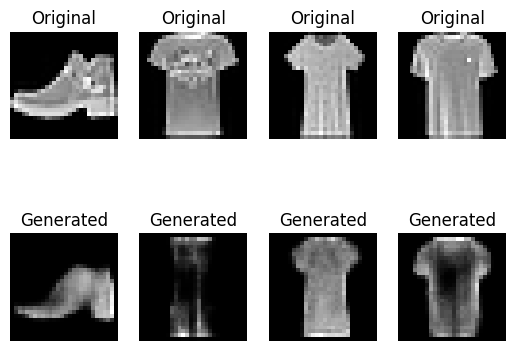

| Epoch:[24]	Train_Loss: 122463.5586
| Epoch:[24]	Valid_Loss: 122152.1589




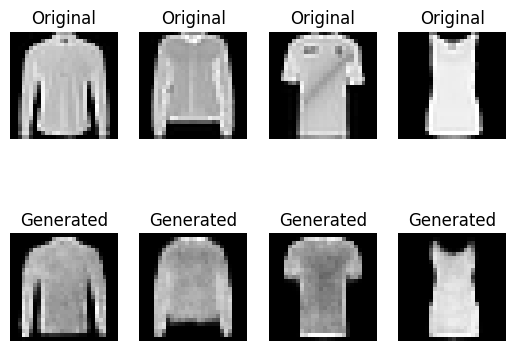

| Epoch:[25]	Train_Loss: 122447.6285
| Epoch:[25]	Valid_Loss: 122135.9313




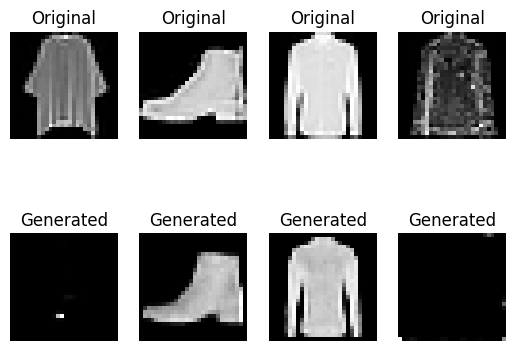

| Test_Loss: 121865.4043




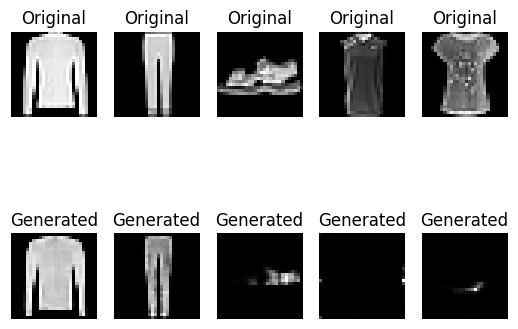

In [11]:
num_epochs, batch_size, num_workers, learning_rate = 25, 256, 8, 0.001
img_size = [fmnist_test[0][0].size(1), fmnist_test[0][0].size(2)]
latent_dim = 40

model_vae = CNN_VAE_1(fmnist_test[0][0].size(0), img_size, latent_dim)
model_vae.to(device)

optimiser = optim.Adam(model_vae.parameters())

train_loss, val_loss = train_val_vae(model_vae, optimiser, num_epochs, num_workers, batch_size, fmnist_train, fmnist_val, img_size)
test_in_imgs, test_out_imgs, means, log_vars, labels, test_loss = test_vae(model_vae, num_epochs, num_workers, batch_size, learning_rate, fmnist_test, img_size)

Generating 5 decoded images from random points generated in the latent space

torch.Size([5, 1, 28, 28])


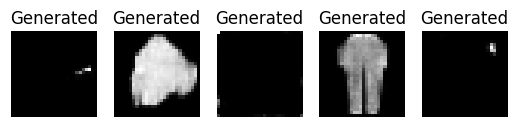

In [12]:
new_imgs = model_vae.generate(5)
disp_img(new_imgs)

Interpolating between 5 sets of two images. Getting the first 10 images from the test datasets as the input images

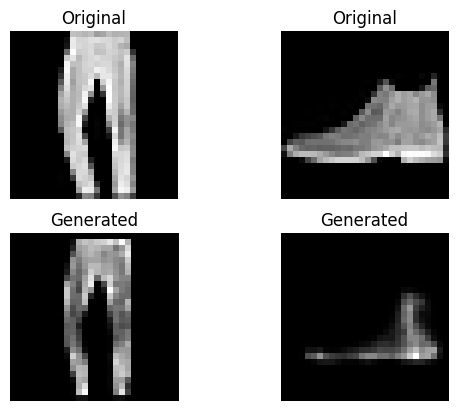

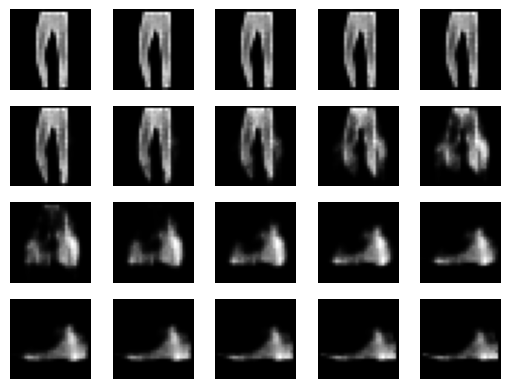

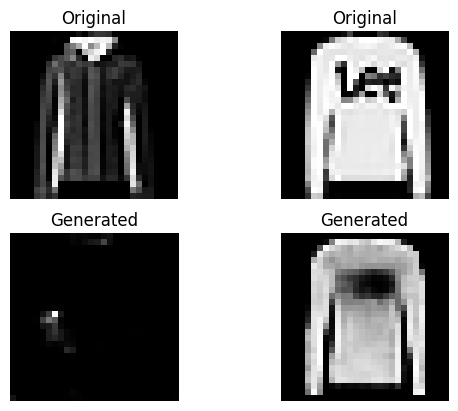

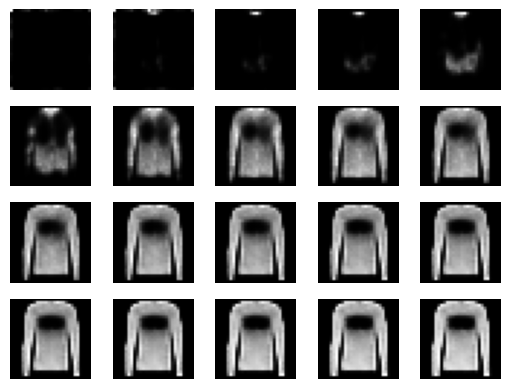

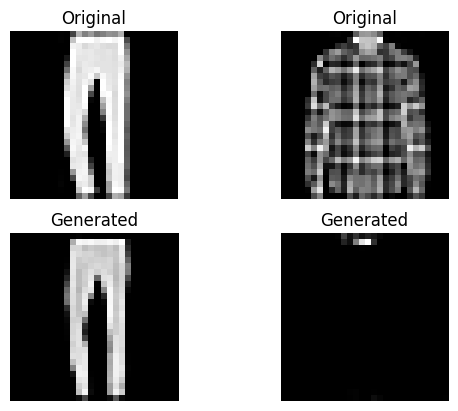

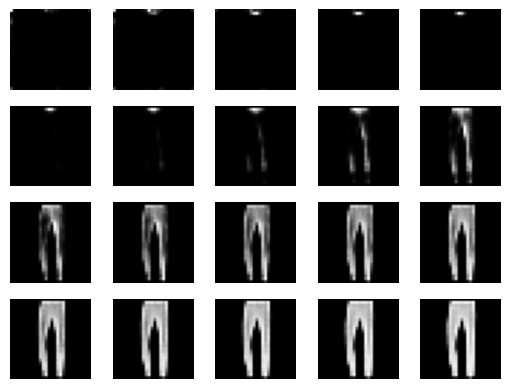

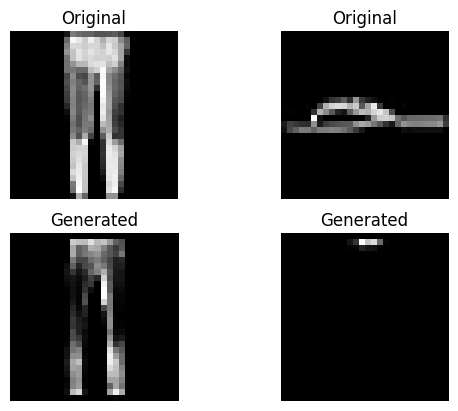

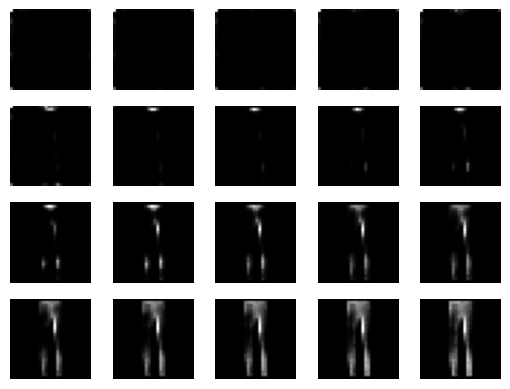

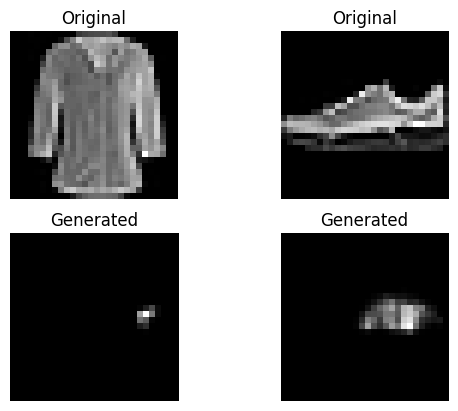

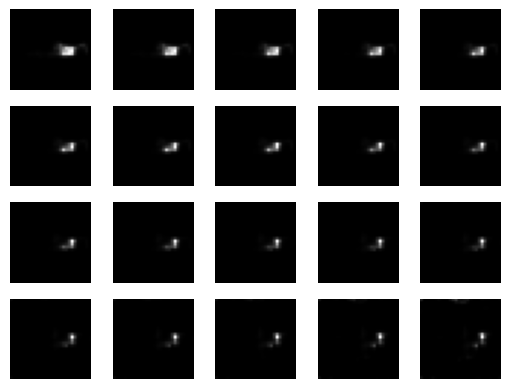

In [13]:
def create_interp(img1_list, img2_list, sample_n, latent_dim):
    for j in range(len(img1_list)):
        inp_imgs = torch.stack((img1_list[j], img2_list[j]))

        out_imgs, mu_imgs, log_var_imgs = model_vae(inp_imgs.to(torch.float).to(device))

        disp_org_dec(torch.squeeze(inp_imgs), torch.squeeze(out_imgs.detach().cpu()).numpy(), 2)

        mu1, mu2 = mu_imgs.detach().cpu()[0], mu_imgs.detach().cpu()[1]

        latent_pts = torch.empty((sample_n, latent_dim)).to(device)

        for i in range(sample_n):
            latent_pts[i] = ((i/(sample_n-1)) * mu1 + (1-(i/sample_n)) * mu2)

        interp_imgs = model_vae.decode(latent_pts)

        disp_interp_imgs(torch.squeeze(interp_imgs.detach().cpu()).numpy())

img1_list = [fmnist_test[i][0] for i in range(5)]
img2_list = [fmnist_test[i][0] for i in range(5,10)]

create_interp(img1_list, img2_list, 20, latent_dim)